In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

df = pd.read_csv("Automobile.csv")
df.head()

,name,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,chevrolet chevelle malibu,18.0,8,307.0,130.0,3504,12.0,70,usa
1,buick skylark 320,15.0,8,350.0,165.0,3693,11.5,70,usa
2,plymouth satellite,18.0,8,318.0,150.0,3436,11.0,70,usa
3,amc rebel sst,16.0,8,304.0,150.0,3433,12.0,70,usa
4,ford torino,17.0,8,302.0,140.0,3449,10.5,70,usa


In [20]:
max_depth = 100

x = df.drop(["mpg","name","origin"],axis=1)
y = df["mpg"]

def knn_impute(df, n_neighbors=6):
    df_filled = df.copy()
    # Iterate over each column
    for column in df.columns:
        # Separate rows with and without missing values
        known_data = df_filled[df_filled[column].notnull()]
        missing_data = df_filled[df_filled[column].isnull()]

        if not missing_data.empty:
            # Prepare data for KNN
            X_train = known_data.drop(columns=[column])
            y_train = known_data[column]
            X_test = missing_data.drop(columns=[column])

            knn = KNeighborsRegressor(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)

            # Predict and fill missing values
            df_filled.loc[df_filled[column].isnull(), column] = knn.predict(X_test)

    return df_filled
x = knn_impute(x)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=1)
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [21]:

r2 = []
mean= []
for i in range(2,1000,10):
    reg = RandomForestRegressor(max_leaf_nodes=i,n_estimators=1000,random_state=1)
    reg.fit(x_train,y_train)

    y_pred = reg.predict(x_test)

    mean.append(mean_squared_error(y_test,y_pred))
    r2.append(r2_score(y_test,y_pred))
print(f"Least mean squared error: {min(mean)}")
print(f"Max r2 score: {max(r2)}")
best = mean.index(min(mean))
best_r2 = r2.index(max(r2))
print(f"Best max leaf node according to MSE: {2+(10*best)}, R2: {2+(10*best_r2)}")


Least mean squared error: 5.40013655568333
Max r2 score: 0.904152842076822
Best max leaf node according to MSE: 142, R2: 142


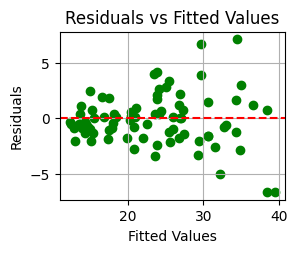

In [22]:
reg = RandomForestRegressor(max_leaf_nodes=2+(10*best),n_estimators=1000,random_state=1)
reg.fit(x_train,y_train)

y_pred = reg.predict(x_test)
residuals = y_test - y_pred
plt.subplot(2, 2, 2)
plt.scatter(y_pred, residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.grid(True)
plt.show()

In [23]:
num_folds = 10
reg = DecisionTreeRegressor(max_depth=100,random_state=1)
fold_size = len(x) // num_folds


r2_scores = []
for i in range(num_folds):
    start_idx = min(i * fold_size, len(x))
    end_idx = min((i + 1) * fold_size, len(x))
    
    x_train_fold = pd.concat([x.iloc[:start_idx], x.iloc[end_idx:]])
    y_train_fold = pd.concat([y.iloc[:start_idx], y.iloc[end_idx:]])
    x_test_fold = x.iloc[start_idx:end_idx]
    y_test_fold = y.iloc[start_idx:end_idx]
    
    reg.fit(x_train_fold, y_train_fold)
    y_pred_fold = reg.predict(x_test_fold)
    
    r2_fold = r2_score(y_test_fold, y_pred_fold)
    r2_scores.append(r2_fold)

avg_r2_score = sum(r2_scores) / num_folds
print("Average r2 score:", avg_r2_score)

Average r2 score: 0.620084626238308


In [24]:
decision_tree = DecisionTreeRegressor(max_depth=max_depth,random_state=1)

bag = BaggingRegressor(decision_tree,n_estimators=1000,bootstrap=False)

bag.fit(x_train,y_train)

BaggingRegressor(bootstrap=False,
                 estimator=DecisionTreeRegressor(max_depth=100, random_state=1),
                 n_estimators=1000)

In [25]:
y_pred2 = bag.predict(x_test)

score = r2_score(y_test,y_pred2)

print(f"R2 score is: {score}")

R2 score is: 0.7207576604866193


In [26]:
lreg = LinearRegression()

lreg.fit(x_train,y_train)
y_pred3 = lreg.predict(x_test)
score = r2_score(y_test,y_pred3)

print(f"R2 score is: {score}")

R2 score is: 0.8424797362918521
